# Analysis of the Clement-Ziza et al. 2014 RNA-seq data

### Loading in the data

In [24]:
#importing standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.multitest as smm
import warnings
#suppress warnings
warnings.filterwarnings('ignore')
%matplotlib inline  
plt.rcParams["font.family"] = "Arial"
root = '/Users/k23030440/github_projects/S.-Pombe-MLPs/'
#reading the data: /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement-Ziza et al 2014/Clement-Ziza processed.tsv
data = pd.read_csv(root + 'external data/Clement-Ziza et al 2014/Clement-Ziza processed.tsv', sep='\t', header=11,index_col=0)
systematic_names = data.index

### Renaming genes to their common names

In [25]:

gene_desc = pd.read_csv(root + 'external data/Pombase files/gene_IDs_names_products.tsv', sep='\t', header=None,)

indices_=[]
for i in data.index:
    if i in gene_desc[0].values:
        #if there is a value in the second column, that is not nan
        if str(gene_desc[gene_desc[0]==i][2].values[0])!='nan':
            
            indices_.append(gene_desc[gene_desc[0]==i][2].values[0])
        else:
            indices_.append(i)
            
    else:
            indices_.append(i)
            
data.index=indices_


### Loading the sample-genotype map from Clement-Ziza and assigning sequencing samples to specific segregants.

In [26]:
#load sample - genotype map from /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement-Ziza et al 2014/Clement-Ziza sample - genotype map.xlsx
map = pd.read_excel(root + '/external data/Clement-Ziza et al 2014/Clement-Ziza sample - genotype map.xlsx',header=None)
map.columns = ['sample','genotype']
#save genotypes
true_genotypes = map['genotype']
#if a genotype is in the list more than once, put an number after it
for i in map.genotype.unique():
    if i in map.genotype.value_counts()[map.genotype.value_counts()>1].index:
        map.loc[map.genotype==i,'genotype'] = [str(i)+"_rep_"+str(int(j)+1) for j in range(map.genotype.value_counts()[i])]


for i in data.columns:
    ind = np.where(map["sample"]==i)[0]
    #rename the ind-th column of data to the genotype of the sample
    data.rename(columns={i:map["genotype"][ind].values[0]},inplace=True)

data.head()

,R1_1_rep_1,R1_2,R1_4_rep_1,R1_3_rep_1,R1_5_rep_1,R1_6_rep_1,R1_7_rep_1,R1_8_rep_1,R1_9_rep_1,R1_10_rep_1,...,R1_4_rep_2,R1_5_rep_2,R1_6_rep_2,R1_7_rep_2,R1_8_rep_2,R1_9_rep_2,R1_10_rep_2,swc5_del_rep_1,swc5_del_rep_2,swc5_del_rep_3
mrx11,66,31,42,29,22,74,67,61,78,117,...,110,67,70,85,56,30,115,44,48,42
pom34,302,180,420,305,210,480,517,491,672,618,...,647,520,513,450,344,331,568,252,326,285
gls2,2136,1439,2109,2101,1315,2166,2993,2298,3532,2568,...,2147,2286,2408,1618,1989,1624,2662,1163,1545,1102
taf11,195,139,256,200,197,307,342,324,407,269,...,412,499,438,287,305,335,360,245,244,300
jmj2,135,83,149,132,94,191,197,178,269,225,...,264,247,277,212,245,170,261,107,165,122


In [27]:
#DEseq normalisation
#save column names and indices, then create a numpy matrix of the data
col_names = data.columns
ind_names = data.index
data = data.values

#calculate row-wise geometric means
row_means = np.exp(np.mean(np.log(data+1),axis=1))
#create a matrix with the ratios of the datapoints to the row means
data_ = data/row_means[:,None]
#take the median of the ratios in each column
col_medians = np.median(data_,axis=0)
#divide data in each column by the median of the ratios in that column
data_ = data/col_medians

### Quick plot of how the normlisation method adjusted total counts for samples

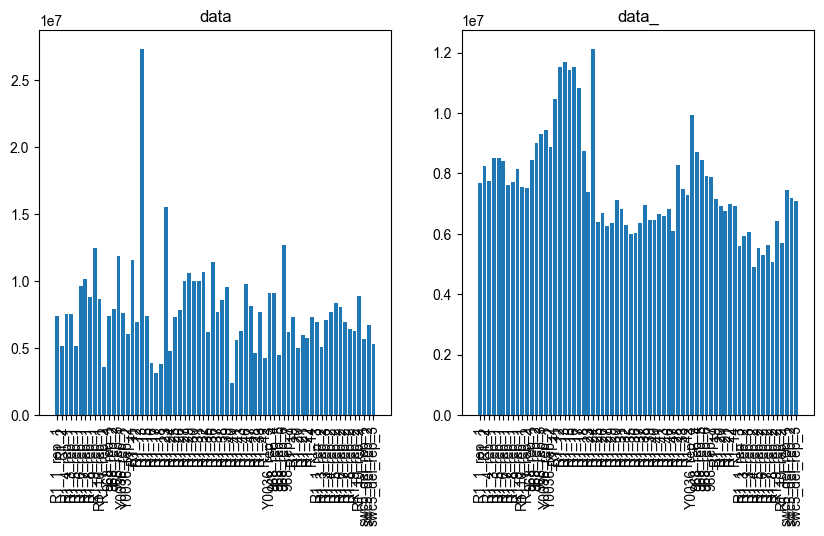

In [28]:
#plot the column totals in data and in data_
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(len(col_names)),np.sum(data,axis=0))
plt.xticks(range(len(col_names)),col_names,rotation=90)
plt.title('data')
plt.subplot(1,2,2)
plt.bar(range(len(col_names)),np.sum(data_,axis=0))
plt.xticks(range(len(col_names)),col_names,rotation=90)
plt.title('data_')
plt.show()


### Importing data on MLPs

In [29]:
#import washing phenotypes /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Celeste's original code/QTL mapping/washing_phenotypes.csv
washing = pd.read_csv(root + "Bence folder/Image processing - Adhesion assay/segregants_emm.csv",header=0,index_col=0)
#keep first two cols
washing = washing.iloc[:,:2]
washing.columns = ['genotype','phenotype']
#in genotype change R to R1_
washing.genotype = ["R1_" + i[1:] if i[0]=="R" else i for i in washing.genotype]
washing.genotype = ["968"  if i=="JB50" else i for i in washing.genotype]   
washing.genotype = ["YOO36"  if i=="JB759" else i for i in washing.genotype]
#import filtering phenotypes /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Celeste's original code/QTL mapping/filtering_phenotypes.csv
filtering = pd.read_csv(root + 'internal data/Filtering assay/filtering_phenotypes.csv',header=0,index_col=0)
filtering.columns = ['genotype','phenotype']
#in filtering change X968 to 968
filtering.genotype = ["968"  if i=="X968" else i for i in filtering.genotype]

#merge the two dataframes by genotype, and name the phenotypes washing and filtering
phenotypes = pd.merge(washing,filtering,on='genotype')
phenotypes.columns = ['genotype','washing','filtering']
phenotypes

,genotype,washing,filtering
0,968,0.121752,0.081319
1,R1_1,0.049880,0.104369
2,R1_10,0.021801,0.053252
3,R1_11,0.058332,0.063310
4,R1_12,0.491190,0.867539
5,R1_13,0.032526,0.021799
6,R1_14,0.056190,0.049553
7,R1_15,0.034107,0.031385
8,R1_16,0.017561,0.023788
9,R1_17,0.020886,0.184335


### Only keep RNA-seq data for strains that we have measurements on

In [30]:
#create an array called genotypes_to_retain, which has the entries from true_genotypes removing _rep_1 and _rep_2
genotypes_to_retain = [i.split('_rep_')[0] for i in true_genotypes]
#only retain the ones that are in the phenotypes dataframe
genotypes_to_retain = [i for i in genotypes_to_retain if i in phenotypes.genotype.values]
#subset col_names to include only the genotypes that are in genotypes_to_retain, or those + _rep_...
col_names_retained = [i for i in col_names if i in genotypes_to_retain or i.split('_rep_')[0] in genotypes_to_retain]
#index of which col_names were retained
ind = [i in col_names_retained for i in col_names]
#subset the data to only include the genotypes in genotypes_to_retain in the same order
data_full = data_.copy()
data_ = data_[:,ind]

In [31]:
data_ .shape

(6737, 62)

### Take mean of samples with multiple replicates

In [32]:
col_names_retained_wo_reps = [i.split('_rep_')[0] for i in col_names_retained]

#create a matrix of zeros with  dimensions: data.shape[0] and unique col_names_retained_wo_reps entries
data = np.zeros((data_.shape[0],len(np.unique(col_names_retained_wo_reps))))

for i,j in enumerate(np.unique(col_names_retained_wo_reps)):
    #find the indices of the columns in data_ that correspond to the genotype j

      ind = [k for k in range(len(col_names_retained)) if col_names_retained[k].split('_rep_')[0]==j]
      #take the mean of the columns in data_ that correspond to the genotype j
      data[:,i] = np.mean(data_[:,ind],axis=1)
final_cols = np.unique(col_names_retained_wo_reps)

### Create a DF with genotype and phenotype values in the same order as the samples in the RNA-seq dataset

In [33]:

#create a new df for phenotypes with reordering phenotypes such that genotype matches the order of those in col_names_retained_wo_reps
phenotypes_ = pd.DataFrame(columns=['genotype','washing','filtering'])
for i in final_cols:
    phenotypes_ = pd.concat([phenotypes_,phenotypes.loc[phenotypes.genotype==i,:]],axis=0)
phenotypes_.index = range(len(phenotypes_))
phenotypes_
#extract the two phenotypes as arrays from the df
washing = phenotypes_['washing'].values
filtering = phenotypes_['filtering'].values

### Perform correlation analysis between phenotypes and gene expression

In [34]:

def find_correlated_genes(data,phenotype, only_sig=True, add_function=True,systematic_names=systematic_names ):
    df = pd.DataFrame(columns=['gene','correlation','p-value'])
    with warnings.catch_warnings():
        for i in range(data.shape[0]):
            #create temp df with the gene expression and the phenotype df
            temp = pd.DataFrame({'gene':data[i,:],'phenotype':phenotypes_[phenotype], 'genotype':final_cols})
            
            cor = st.spearmanr(temp['gene'],temp['phenotype'])
            df = pd.concat([df,pd.DataFrame({'gene':ind_names[i],'correlation':cor[0],'p-value':cor[1],"systematic_names":systematic_names[i]},index=[0])],axis=0)
    #remove every row that has NaN for p-value
    df = df.dropna(subset=['p-value'])
    #perform BH correction

    df['p-value adj'] = smm.fdrcorrection(df['p-value'])[1]
    #order by p-value
    df = df.sort_values(by='p-value')
    #only retain significant ones
    if only_sig:
        df = df[df['p-value adj']<0.05]
    #for each gene add the function (column 4 in gene_desc)
    if add_function:
        #find the row in gene_desc where the gene name matches either the entry in column 0 or 2
        #add the function from column 4 to the df
        df['function'] = [gene_desc.loc[(gene_desc[0]==i) | (gene_desc[2]==i),4].to_string(index=False)  for i in df.gene]
        #if entry in function is 'Series([], )' then replace with 'unknown'
        df['function'] = [i if i!='Series([], )' else 'unknown' for i in df['function']]
        #if gene name has -antisense- in it, then look for what is after that, and see if it has a function
        #if it does, then add that function to the df
        df["sense function"] = df["function"]
        for i in range(df.shape[0]):
            if '-antisense-' in df.gene.values[i]:
                #find the gene name before -antisense-
                gene_name = df.gene.values[i].split('-antisense-')[0]
                #find the function of that gene
                function = gene_desc.loc[(gene_desc[0]==gene_name) | (gene_desc[2]==gene_name),4].to_string(index=False)
                #if the function is not 'Series([], )' then add it to the df
                if function!='Series([], )':
                    df['sense function'].values[i] = function
                else:
                    df['sense function'].values[i] = 'unknown'

    return df


In [35]:
with warnings.catch_warnings():
    wash_df = find_correlated_genes(data,"washing",only_sig=False)
    filt_df = find_correlated_genes(data,"filtering",only_sig=False)
#save these
wash_df.to_csv('wash_corr.csv')
#correlated with filter
filt_df.to_csv('filter_corr.csv')
filt_df.head(10)
    

,gene,correlation,p-value,systematic_names,p-value adj,function,sense function
0,pfl8,0.780764,2.522393e-10,SPAC1F8.06,0.000002,"cell surface glycoprotein, flocculin Pfl8","cell surface glycoprotein, flocculin Pfl8"
0,pfl3,0.732411,1.075220e-08,SPBC947.04,0.000036,"cell surface glycoprotein, flocculin Pfl3, DIP...","cell surface glycoprotein, flocculin Pfl3, DIP..."
0,SPNCRNA.781,0.709881,4.748847e-08,SPNCRNA.781,0.000105,intergenic RNA (predicted),intergenic RNA (predicted)
0,pfl7,0.701449,7.993057e-08,SPBC359.04c,0.000130,"cell surface glycoprotein, flocculin Pfl7, DIP...","cell surface glycoprotein, flocculin Pfl7, DIP..."
0,mbx2,0.697892,9.903675e-08,SPBC317.01,0.000130,"DNA-binding transcription factor, MADS-box Pvg4","DNA-binding transcription factor, MADS-box Pvg4"
0,ubc4-antisense-1,0.694993,1.176684e-07,SPNCRNA.1382,0.000130,antisense RNA (predicted),ubiquitin conjugating enzyme E2 for APC and SC...
0,pac2,0.686825,1.892505e-07,SPAC31G5.11,0.000156,cAMP-independent regulatory protein Pac2,cAMP-independent regulatory protein Pac2
0,SPNCRNA.1083,0.686561,1.921250e-07,SPNCRNA.1083,0.000156,intergenic RNA (predicted),intergenic RNA (predicted)
0,mfs1,0.684848,2.118235e-07,SPAC17C9.16c,0.000156,plasma membrane xenobiotic transmembrane trans...,plasma membrane xenobiotic transmembrane trans...
0,dea2,0.658762,8.674338e-07,SPBC1198.02,0.000535,adenine deaminase Dea2,adenine deaminase Dea2


### Saving results for Angeli and further analysis

In [36]:
#angeli for flocclation genes
#filt_df, remove genes starting with SPNCRNA
filt_df = filt_df[~filt_df.systematic_names.str.contains('SPNCRNA')]
filt_df_genes = filt_df[["systematic_names","p-value adj"]]
sig_genes = filt_df_genes[filt_df_genes["p-value adj"]<0.05]["systematic_names"].values
background_genes = filt_df_genes["systematic_names"].values
#export to this folder /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli
sig_genes = pd.DataFrame(sig_genes)
sig_genes.to_csv(root + "/Bence folder/Angeli/sig_genes.txt",index=False)
background_genes = pd.DataFrame(background_genes)
background_genes.to_csv(root + "/Bence folder/Angeli/background_filt_genes.txt",index=False)

### Plots for flocculation vs. gene expression

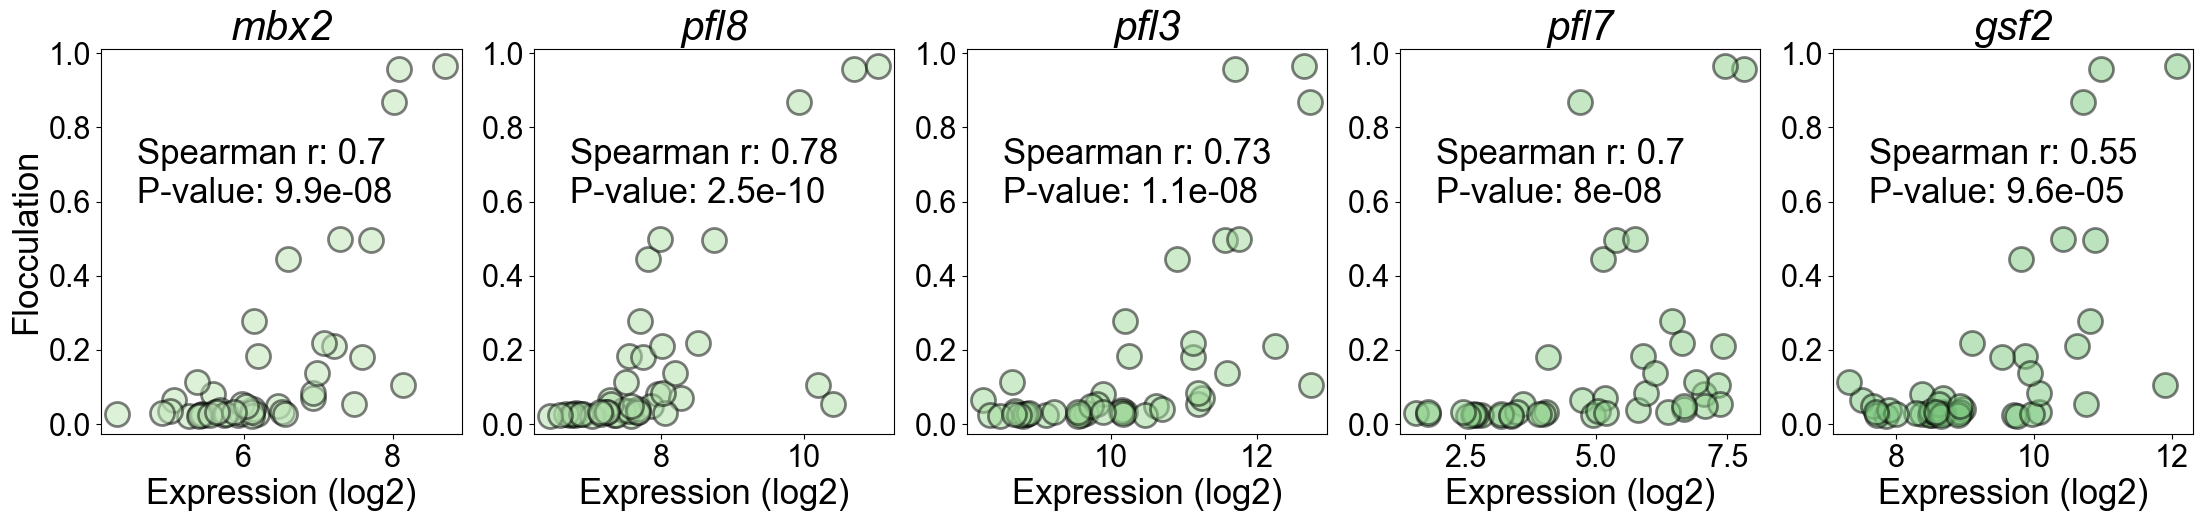

In [37]:
#create 5 figures next to each other
fig, ax = plt.subplots(1,5,figsize=(27,5))
colors = sns.color_palette("Greens", 20)
#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(5),["mbx2","pfl8",  "pfl3","pfl7","gsf2"],colors[5:]):

    #log2 data
    data_log = np.log2(data+1)

    sns.scatterplot(x=data_log[ind_names==j,:][0],y=filtering,color=col,ax=ax[i],alpha=0.5,s=300,edgecolor='k',linewidth=2)

    ax[i].set_xlabel("Expression (log2)",fontsize=25,fontname='Arial')
    
    if i==0:
        ax[i].set_ylabel('Flocculation',fontsize=25)
    
    #arial italic
    ax[i].set_title(j,fontsize=30,fontname='Arial',fontstyle='italic')
    ax[i].tick_params(axis='both', which='major', labelsize=22)
    #plt text the spearman correlations, round both to 2 significant digits
    ax[i].text(0.1,0.7,f'Spearman r: {np.round(st.spearmanr(data_log[ind_names==j,:][0],filtering)[0],2)}',transform=ax[i].transAxes,fontsize=25)
    pval = st.spearmanr(data[ind_names==j,:][0],filtering)[1]
    sig_digits = np.floor(np.log10(pval))
    ax[i].text(0.1,0.6,f'P-value: {np.round(pval,1-int(sig_digits))}',transform=ax[i].transAxes,fontsize=25)

plt.savefig(root + "Figures/All figures/gene_expression corr filter log.svg",format='svg',dpi=400, bbox_inches='tight')
plt.savefig(root + "Figures/All figures/gene_expression corr filter log.png",format='png',dpi=400, bbox_inches='tight')
plt.show()

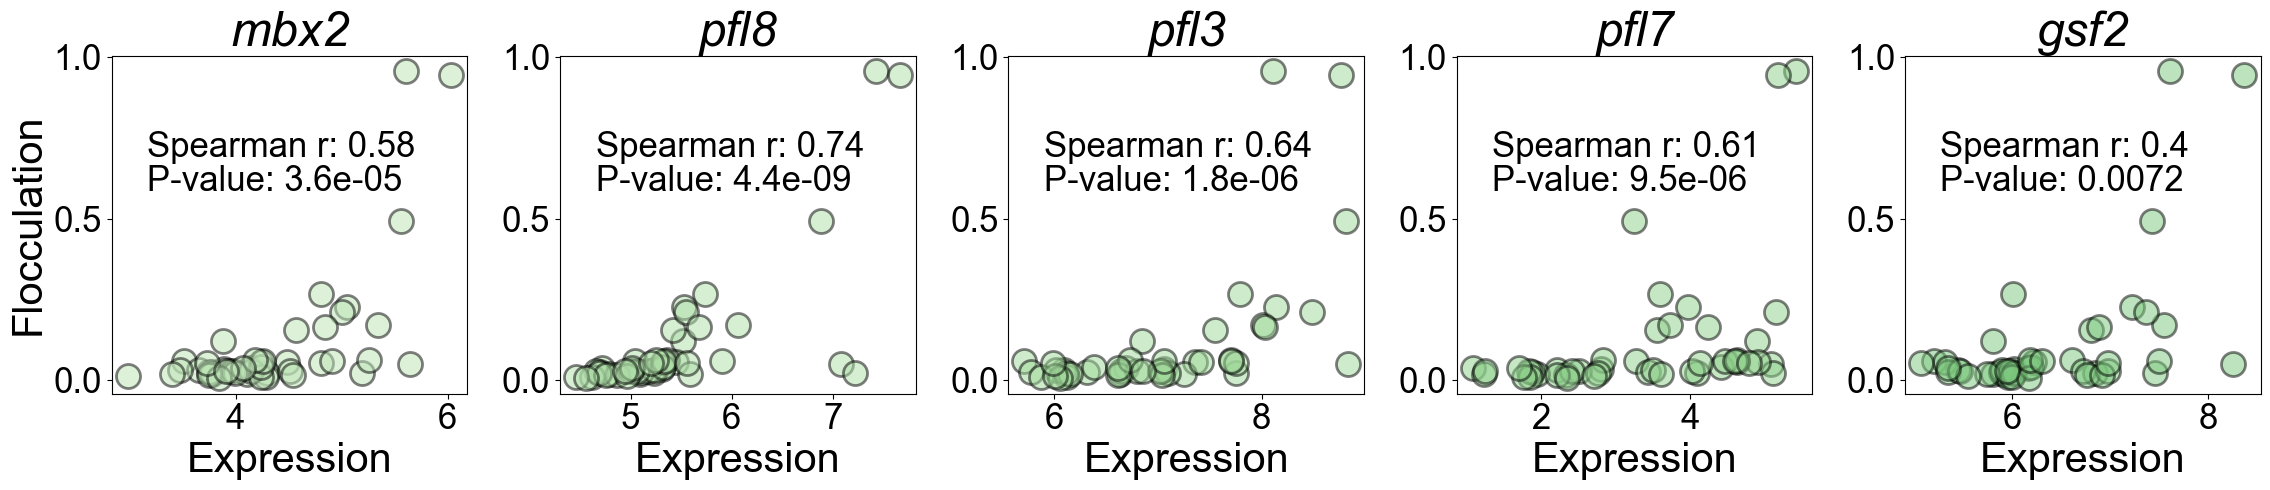

In [38]:
#create 5 figures next to each other
fig, ax = plt.subplots(1,5,figsize=(23,5))
colors = sns.color_palette("Greens", 20)
#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(5),["mbx2","pfl8",  "pfl3","pfl7","gsf2"],colors[5:]):

    #log1p data
    data_log = np.log1p(data)

    sns.scatterplot(x=data_log[ind_names==j,:][0],y=washing,color=col,ax=ax[i],alpha=0.5,s=300,edgecolor='k',linewidth=2)

    ax[i].set_xlabel("Expression",fontsize=30,fontname='Arial')
    
    if i==0:
        ax[i].set_ylabel('Flocculation',fontsize=30)
    
    #arial italic
    ax[i].set_title(j,fontsize=35,fontname='Arial',fontstyle='italic')
    ax[i].tick_params(axis='both', which='major', labelsize=25)
    #plt text the spearman correlations, round both to 2 significant digits
    ax[i].text(0.1,0.7,f'Spearman r: {np.round(st.spearmanr(data_log[ind_names==j,:][0],washing)[0],2)}',transform=ax[i].transAxes,fontsize=25)
    pval = st.spearmanr(data_log[ind_names==j,:][0],washing)[1]
    sig_digits = np.floor(np.log10(pval))
    ax[i].text(0.1,0.6,f'P-value: {np.round(pval,1-int(sig_digits))}',transform=ax[i].transAxes,fontsize=25)
plt.tight_layout()

plt.savefig(root + "Figures/All figures/gene_expression corr wash.svg",format='svg',dpi=400) 
plt.savefig(root + "Figures/All figures/gene_expression corr wash.png",format='png',dpi=400)
plt.show()

### Plots for flocculins vs mbx2

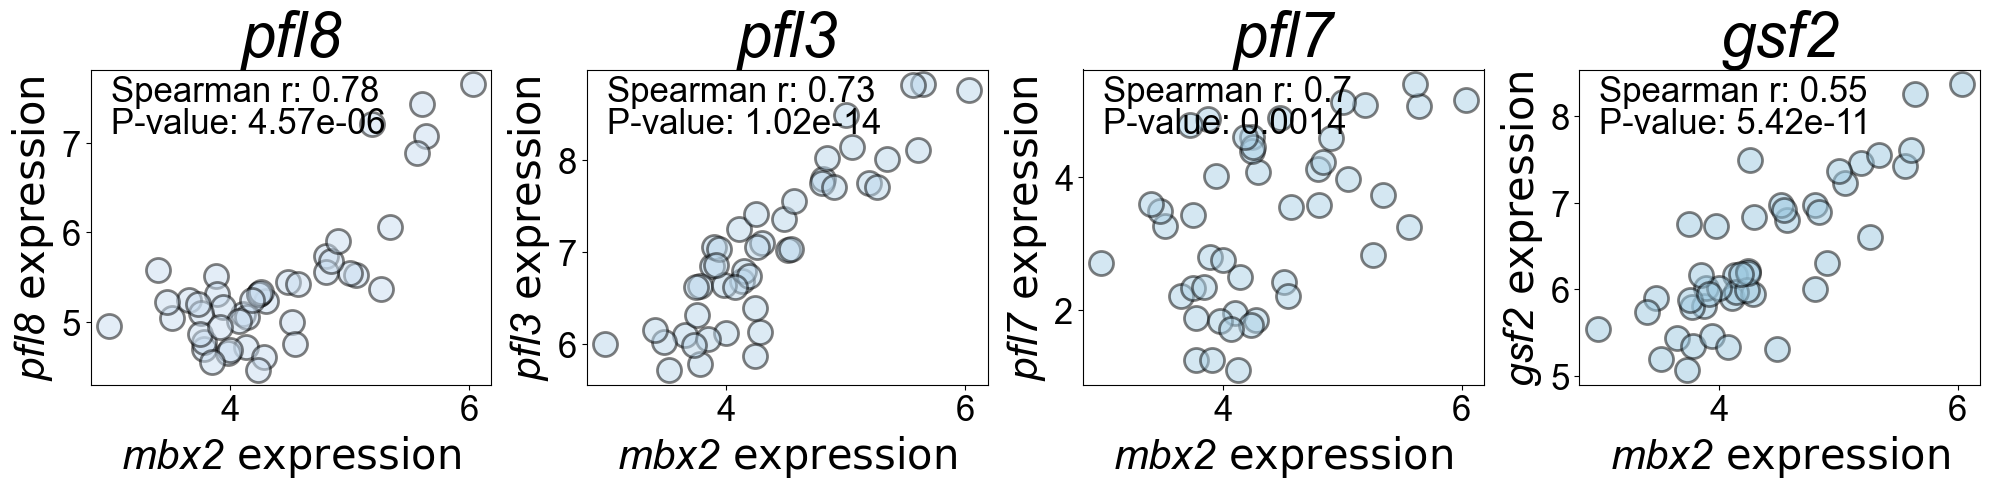

In [39]:
colors = sns.color_palette("Blues", 20)
fig, ax = plt.subplots(1,4,figsize=(20,5))
#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(4),["pfl8",  "pfl3","pfl7","gsf2"],colors[4:]):
    #log1p data
    data_log = np.log1p(data)

    sns.scatterplot(x= data_log[ind_names=='mbx2',:][0],y=data_log[ind_names==j,:][0],color=col,ax=ax[i],alpha=0.5,s=300,edgecolor='k',linewidth=2)
    ax[i].set_xlabel("mbx2" + r'$\mathrm{\ expression}$',fontsize=30,fontname='Arial',fontstyle='italic')
    ax[i].set_ylabel(j + r'$\mathrm{\ expression}$',fontsize=30,fontname='Arial',fontstyle='italic')
    ax[i].set_title(j,fontsize=45,fontname='Arial',fontstyle='italic')
    ax[i].tick_params(axis='both', which='major', labelsize=25)
    #plt text the spearman correlations, round both to 2 significant digits
    ax[i].text(0.05,0.90,f'Spearman r: {np.round(st.spearmanr(data_log[ind_names==j,:][0],filtering)[0],2)}',transform=ax[i].transAxes,fontsize=25)
    pval = st.spearmanr(data_log[ind_names==j,:][0], data_log[ind_names=='mbx2',:][0])[1]
    sig_digits = np.floor(np.log10(pval))
    ax[i].text(0.05,0.80,f'P-value: {np.round(pval,2-int(sig_digits))}',transform=ax[i].transAxes,fontsize=25)
plt.tight_layout()

plt.savefig(root + "Figures/All figures/flocculin mbx2 corr.svg",format='svg',dpi=400) 
plt.savefig(root + "Figures/All figures/flocculin mbx2 corr.png",format='png',dpi=400)
plt.show()
    
    

## Perform differential expression analysis after splitting cells on the the srb11 mutation (In the end the paper uses a similar analysis using DESeq2 in R, but results are comparable)

In [40]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/updated_genotype_matrix_final_pos.tsv
snps = pd.read_csv(root + "/internal data/updated_genotype_matrix_final_pos.tsv", sep="\t")

snps = snps[(snps["position"]==2316851)]
#remove first 4 columns
snps = snps.iloc[:,4:]

In [41]:

snps.reset_index(drop=True, inplace=True)
#snps now contains the genotypes at II:2316554
#remove columns with NaNs
for i in snps.columns:
    if (snps[i].isna().any()):
        snps = snps.drop(i,axis=1)

genotype = snps.loc[0].values
   
index_0= snps.columns[genotype==0]
colnames_0 = snps.columns[genotype==0]
index_1= snps.columns[genotype==1]
colnames_1 = snps.columns[genotype==1]
#iterate through enumerate col_names_retained_wo_reps and save the index of the column names in col_index_0 and col_index_1 deoendibgn on genotype
col_index_0 = []
col_index_1 = []
for i in enumerate(final_cols):
      if (i[1] in colnames_0):
            col_index_0.append(i[0])
      elif (i[1] in colnames_1):
            col_index_1.append(i[0])


In [44]:
df = pd.DataFrame(columns=["gene","mean_exp_0","mean_exp_1","log2fc","pval","pval_adjust"])
for i in ind_names:
    #get expression of gene i
      gene_exp = data[ind_names==i,:]
    
      gene_exp_0 = gene_exp[0,col_index_0]
      gene_exp_1 = gene_exp[0,col_index_1]


    #calculate mean expression of gene i for genotype 0
      mean_exp_0 = np.mean(gene_exp_0)
    #calculate mean expression of gene i for genotype 1
      mean_exp_1 = np.mean(gene_exp_1)
    #clculate log2fc
      log2fc = np.log2(mean_exp_1/mean_exp_0)
    #calculate pval
      pval = st.ttest_ind(gene_exp_0,gene_exp_1)[1]
      pval_adjust = pval*len(ind_names)
    #add to df
      row  = {"gene":i,"mean_exp_0":mean_exp_0,"mean_exp_1":mean_exp_1,"log2fc":log2fc,"pval":pval,"pval_adjust":pval_adjust}
      sub_df = pd.DataFrame(row, index=[0])
      df = pd.concat([df,sub_df],ignore_index=True)
      


In [45]:
#sort based on pval_adjust
df = df.sort_values(by="pval_adjust")
df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Differential expression between II:2316851 TA/T",fontsize=25)
ax.set_xlabel("log2 Fold Change",fontsize=25)
ax.set_ylabel("-log10(P_value)",fontsize=25)
for i in df.index:
      if (df.loc[i,"pval_adjust"]<0.05):
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='red',alpha=0.5,s=50)
      else:
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='blue',alpha=0.1)
#plot a horizontal line at -log10(0.05)
#bonferroni correction
bonf=0.05/len(df)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)

#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a horizontal line at -log10(0.05)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#annotate top 10 genes with their names and make sure these dont overlap. To do this make a matrix of their coordinates and make sure they are far enough apart
matrix = np.zeros((20,2))

for k in range(20):
     
      x = df.loc[k,"log2fc"]
      y = -np.log10(df.loc[k,"pval"])
      
      while (np.min(np.sqrt((matrix[:,0]-x)**2+(matrix[:,1]-y)**2))<0.8):
            #random walk
            if x<0:
                  x = x + np.random.normal(-0.05,0.05)
            else:
                  x = x + np.random.normal(0.05,0.05)
            y = y + np.random.normal(0,0.05)
      
      #if df.loc[k,"gene"] is less than 5 characters long, annotate it 0.1 above the point
      if (len(df.loc[k,"gene"])<5):
            ax.annotate(df.loc[k,"gene"],(x,y),fontsize=18)
            ax.plot([x,df.loc[k,"log2fc"]],[y,-np.log10(df.loc[k,"pval"])],color='black',alpha=0.3)
      else:
            x=x+1000
            y=y+1000
      matrix[k,0] = x
      matrix[k,1] = y
#increase fontsize of axis labels and title
ax.tick_params(labelsize=15)

# Repeat with DESeq2 and plot that data

In [46]:
#import results from DESeq2 root + Bence folder/Analysis of Clement-Ziza RNA-seq/DESeq2/DE_results.csv
deseq = pd.read_csv(root + "/Bence folder/Analysis of Clement-Ziza RNA-seq/DESeq2/DE_results.csv")


indices_=[]
for i in deseq["Unnamed: 0"].values:
    if i in gene_desc[0].values:
        #if there is a value in the second column, that is not nan
        if str(gene_desc[gene_desc[0]==i][2].values[0])!='nan':
            
            indices_.append(gene_desc[gene_desc[0]==i][2].values[0])
        else:
            indices_.append(i)
            
    else:
            indices_.append(i)
            
deseq["Unnamed: 0"]=indices_
#renae it to gene
deseq.rename(columns={"Unnamed: 0":"gene"},inplace=True)
deseq.head(5)

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,pfl8,361.256550,2.195922,0.258359,8.499512,1.903894e-17,1.215637e-13
1,isp3,45.915145,2.634801,0.431001,6.113210,9.764703e-10,1.558691e-06
2,SPACUNK4.17,166.072799,1.686556,0.294753,5.721926,1.053231e-08,9.939777e-06
3,hsp3101,110.740556,1.578567,0.277263,5.693393,1.245391e-08,9.939777e-06
4,gsf2,914.233745,1.657751,0.297561,5.571133,2.530879e-08,1.469060e-05


In [49]:
#how many hits
deseq[deseq["padj"]<0.05].shape

(552, 7)

In [51]:
#sort based on pval_adjust
df = deseq.copy()

fig, ax = plt.subplots(figsize=(7,7))
ax.set_title("Differential expression between II:2316851 TA/T",fontsize=25)

for i in df.index:
      #if mbx2, gsf2, pfl3, pfl5, pfl9
      if df.loc[i,"gene"] not in ["mbx2","gsf2","pfl3","pfl5","pfl9","pfl8"]:
            
            if (df.loc[i,"padj"]<0.05):
                  ax.scatter(df.loc[i,"log2FoldChange"],-np.log10(df.loc[i,"pvalue"]),c='orange',alpha=0.2,s=75)
            else:
                  ax.scatter(df.loc[i,"log2FoldChange"],-np.log10(df.loc[i,"pvalue"]),c='blue',alpha=0.12)

      else:
            ax.scatter(df.loc[i,"log2FoldChange"],-np.log10(df.loc[i,"pvalue"]),c='red',alpha=0.8,s=80)
#plot a horizontal line at -log10(0.05)

#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.2, linewidth=3)
#annotate top genes with their names and make sure these dont overlap. To do this make a matrix of their coordinates and make sure they are far enough apart
matrix = np.zeros((250,2))

for k in range(250):
     
      x = df.loc[k,"log2FoldChange"]
      y = -np.log10(df.loc[k,"pvalue"])
      
      while (np.min(np.sqrt((matrix[:,0]-x)**2+(matrix[:,1]-y)**2))<1.1):
            #random walk
            if x<0:
                  x = x + np.random.normal(-0.05,0.02)
            else:
                  x = x + np.random.normal(0.05,0.02)
            y = y + np.random.normal(0,0.05)
      
      #if df.loc[k,"gene"] is less than 5 characters long, annotate it 0.1 above the point
      if (len(df.loc[k,"gene"])<5):
            
            #if contains pfl or mbx or gsf
            if ("pfl" in df.loc[k,"gene"]) or ("mbx" in df.loc[k,"gene"]) or ("gsf2" in df.loc[k,"gene"]):
                  #italics
                  ax.plot([x,df.loc[k,"log2FoldChange"]],[y,-np.log10(df.loc[k,"pvalue"])],color='red',alpha=0.4)
                  ax.annotate(df.loc[k,"gene"],(x,y),fontsize=25,color='red',fontstyle='italic')
                  matrix[k,0] = x
                  matrix[k,1] = y


#increase fontsize of axis labels and title
ax.tick_params(labelsize=25)
#y axis name
ax.set_ylabel("-log10(P-value)",fontsize=28)
#x axis name
ax.set_xlabel("log2 Fold Change",fontsize=28)
#tight layout     
plt.tight_layout()
#save figure
plt.savefig(root + "Figures/All figures/diff_exp.svg",format='svg',dpi=400) 
plt.savefig(root + "Figures/All figures/diff_exp.png",format='png',dpi=400)

In [ ]:
#find all genes starting with pfl
df[df.gene.str.contains("pfl")].head(10)

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,pfl8,361.256550,2.195922,0.258359,8.499512,1.903894e-17,1.215637e-13
7,pfl9,155.130405,1.937452,0.367849,5.266981,1.386853e-07,5.534410e-05
111,pfl3,1836.497624,1.387695,0.367480,3.776244,1.592110e-04,6.314052e-03
164,pfl5,145.405521,0.739075,0.207573,3.560556,3.700699e-04,1.006371e-02
793,pfl7,57.695719,1.357519,0.540411,2.512014,1.200442e-02,7.626692e-02
1240,pfl4,477.914880,0.310468,0.146384,2.120918,3.392870e-02,1.419625e-01
3508,pfl2,25183.859935,0.227701,0.284010,0.801736,4.227059e-01,6.115969e-01
5081,pfl6,0.887727,1.352373,0.974723,1.387444,1.653065e-01,NaN


In [74]:
#finding logfold change for mbx2 specifically
df[df.gene=="mbx2"]
#raise 2 to the power of the log2fc to get the fold change
2**df[df.gene=="mbx2"].log2FoldChange.values[0]

2.7193687247477496

### All used packages


In [75]:
%load_ext watermark
%watermark


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-11-04T16:02:35.156745+00:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [76]:
%watermark --iversions



statsmodels: 0.13.5
pandas     : 1.4.4
numpy      : 1.23.4
matplotlib : 3.8.0
scipy      : 1.11.3
seaborn    : 0.13.0

